In [1]:
#NN keras model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding
import re
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [2]:
import numpy as np
import statsmodels.api as sm
import pylab
import scipy.stats as stats

In [3]:
#load data
# C:\Users\Kurt\Desktop\COD\wgu\Capstone
sent_list = []
file1 = 'C:/Users/Kurt/Desktop/COD/wgu/Capstone/Tweets.csv/Tweets.csv'
# file1 = 'C:/Users/Kurt/Desktop/COD/wgu/D213/sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt'
# file2 = 'C:/Users/Kurt/Desktop/COD/wgu/D213/sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt'
# file3 = 'C:/Users/Kurt/Desktop/COD/wgu/D213/sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt'
# with open(file1,'r') as f:
#     sent_list.append(f.readline())

In [4]:
# sent_list[0]
import pandas as pd
df = pd.read_csv(file1)
# df1 = pd.read_csv(file1, sep="\t", header=None)
# df1.columns=['sent','y']
# df2 = pd.read_csv(file2, sep="\t", header=None)
# df2.columns=['sent','y']
# df3 = pd.read_csv(file3, sep="\t", header=None)#748 volume
# df3.columns=['sent','y']

# df=pd.concat([df1,df2,df3],axis=0,ignore_index=True)

In [5]:
df.describe()
# df3.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
#build into def in case I need to switch between
def revWordIndex(w_ind):
    reverse_word_index = dict([(value,key)for(key,value)in w_ind.items()])
    return reverse_word_index

In [8]:
def decode_review(text):
    rev=revWordIndex(word_index)
    return " ".join([rev.get(i,"?")for i in text])

In [9]:
#encode method
def encode_review(text):
    encoded=[1]    
    for word in text:
        if word.lower() in word_index:
            encoded.append(word_index[word.lower()])
        else:
            encoded.append(2)
    return encoded

In [10]:
# Text Preprocess step, lowercases, tokenizes, de-accents
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True,min_len=2,max_len=25))      

    

In [11]:
#some basic regex removal
def depure_data(data):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'',data)
    data = re.sub('\S*@\S*\s?', '', data)
    data = re.sub('\s+', ' ', data)
    data = re.sub("\'", "", data)
    return data

In [12]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [13]:
#Need a way to update the word_index
from gensim.corpora.dictionary import Dictionary

def updateWordDict(doc,wind):
    new_word_index = Dictionary([doc])
    a=revWordIndex(new_word_index)
    for x in a:
        if x.lower() in wind:
            pass
        else:
            #add word to word_index and increment value by max+1
            wind[x.lower()]=max(wind.values())+1
    return wind

def getWordDict(doc):
    a = Dictionary(doc)
    b = revWordIndex(a)
    return b

def preProc(doc):
    temp = []
    for i in doc:
        temp.append(depure_data(i))

    data_words = list(sent_to_words(temp))
    return data_words

In [14]:
#create word index on our data
# word_index = data.get_word_index()
# word_index ={}
#preprocess before creating word index
docs=df.text.tolist()
# docs
#clean list
cdocs=preProc(docs)
#get word_index 
word_index = getWordDict(cdocs)

In [15]:

#this will augment a word_index with padding by shifting values as default object starts at 0
word_index = {k:(v+3) for k,v in word_index.items()}

word_index["<PAD>"]=0
word_index["<START>"]=1
word_index["<UNK>"]=2
word_index["<UNUSED>"]=3

In [16]:
docs[0]
cdocs[0]

['what', 'said']

# EDA

In [17]:
a=[]
for x in cdocs:#get cdocs first
    a.append(len(x))

In [18]:
#includes spaces, counts characters
a[5]

20

In [19]:
cdocs[5]

['seriously',
 'would',
 'pay',
 'flight',
 'for',
 'seats',
 'that',
 'didnt',
 'have',
 'this',
 'playing',
 'its',
 'really',
 'the',
 'only',
 'bad',
 'thing',
 'about',
 'flying',
 'va']

In [20]:
docs[5]

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

<AxesSubplot:>

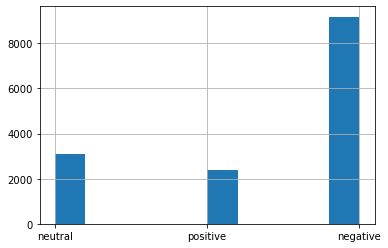

In [21]:
#need to convert string to numeric for tensor
df.airline_sentiment.hist()

In [23]:
#Transform classification
df.airline_sentiment.replace({'negative':0,'neutral':1,'positive':2},inplace=True)


In [24]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,2,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


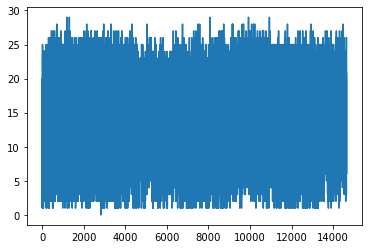

In [25]:
import matplotlib.pyplot as plt
plt.plot(a, label='sentence length')

In [26]:
import numpy as np
np.median(a)

16.0

In [27]:
from collections import Counter
d = Counter(a)

<BarContainer object of 30 artists>

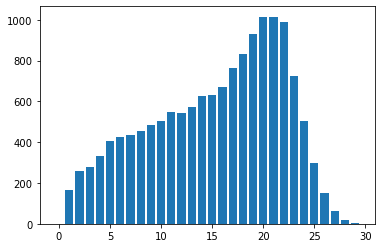

In [28]:
# d
plt.bar(d.keys(),d.values())

In [29]:
# a
tar=np.array(a, dtype=object)

C:\Users\Kurt\anaconda3\envs\TestTensor\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

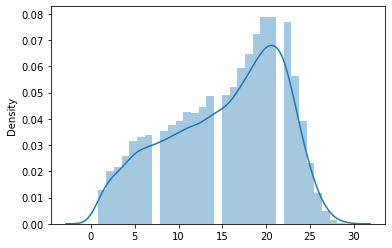

In [30]:
#density plot
import seaborn as sns
sns.distplot(tar,hist=True,kde=True)

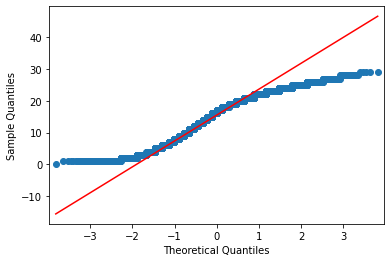

In [31]:

sm.qqplot(tar, line='q')
pylab.show()

In [32]:
#cut off some of the outliers
dd = {x: count for x, count in d.items() if x <30}


In [33]:
# max(dd.values())
max(dd.keys())

24

<BarContainer object of 25 artists>

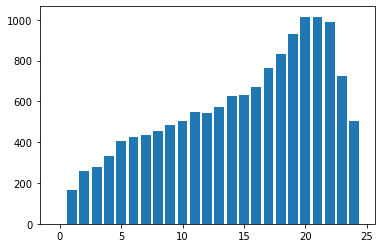

In [34]:
#over 90% below 25 characters
plt.bar(dd.keys(),dd.values())

In [36]:
max(word_index.values())

11196

In [37]:
#transform, hotencode
df_onehot = pd.get_dummies(df[['airline_sentiment','text']],columns=['airline_sentiment'],prefix='sentiment')

In [38]:
df_onehot.head()
# df[['airline_sentiment','text']].head()

,text,sentiment_0,sentiment_1,sentiment_2
0,@VirginAmerica What @dhepburn said.,0,1,0
1,@VirginAmerica plus you've added commercials t...,0,0,1
2,@VirginAmerica I didn't today... Must mean I n...,0,1,0
3,@VirginAmerica it's really aggressive to blast...,1,0,0
4,@VirginAmerica and it's a really big bad thing...,1,0,0


In [68]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         14640 non-null  object
 1   sentiment_0  14640 non-null  uint8 
 2   sentiment_1  14640 non-null  uint8 
 3   sentiment_2  14640 non-null  uint8 
dtypes: object(1), uint8(3)
memory usage: 157.4+ KB


In [40]:
import numpy as np
#need to shuffle the df first
df = df_onehot.sample(frac=1)
s=2000
data_to_list = df[s:].text.tolist()
test_to_list =df[:s].text.tolist()


In [41]:
#3way classification
t1_train_labels_onehot = np.array(df[s:][['sentiment_0','sentiment_1','sentiment_2']])
t1_test_labels_onehot = np.array(df[:s][['sentiment_0','sentiment_1','sentiment_2']])

In [69]:
t1_train_labels_onehot[0]

array([0, 0, 1], dtype=uint8)

In [43]:
# print(len(t1_train_labels),len(t1_test_labels))
print(len(t1_train_labels_onehot),len(t1_test_labels_onehot))

12640 2000


In [44]:

data_words = preProc(data_to_list)

In [45]:

test_words = preProc(test_to_list)

In [46]:
#
# def getLen(docs):
#     a=[]   
#     for x in docs:#get cdocs first
#         a.append(len(x))
#     return a

In [47]:
#set vars for text len on both sampels
# test_len=getLen(test_words)
# train_len=getLen(data_words)


In [48]:
#test of text len
# test_array=np.array(test_len, dtype=object)
# train_array=np.array(train_len,dtype=object)


In [70]:
#zip together to provide test and train datasets
train_data_zip = pd.DataFrame(zip(data_words,t1_train_labels_onehot),columns=['cleaned_text','Classification'])
# train_data_zip.head()
test_data_zip =  pd.DataFrame(zip(test_words,t1_test_labels_onehot),columns=['cleaned_text','Classification'])
# test_data_zip.head()

In [71]:
#out to file
path="C:/Users/Kurt/Desktop/COD/wgu/Capstone/"
test_data_zip.to_csv(path+'test.csv')
train_data_zip.to_csv(path+'train.csv')

In [72]:

t1_encoded=[]
for x in data_words:
    t1_encoded.append(encode_review(x))


In [73]:
t1_encoded[5]

[1, 490, 98, 98, 74, 10, 594]

In [74]:
decode_review(t1_encoded[5])


'<START> thank you you do the same'

In [75]:
print(data_words[5])

['thank', 'you', 'you', 'do', 'the', 'same']


In [76]:
train_array[5]

6

In [77]:
#turn into array
encoded_train = np.array(t1_encoded, dtype=object)

In [78]:
encoded_train[0]

[1, 64, 29, 1651, 42, 490, 98]

In [79]:
t2_encoded = []
for x in test_words:
    t2_encoded.append(encode_review(x))

In [80]:
encoded_test = np.array(t2_encoded, dtype=object)

In [81]:
t1_train_labels_onehot[0]

array([0, 0, 1], dtype=uint8)

In [82]:
#create def
def call_pred(text,ltr,model):
    temp =depure_data(text)
    test_review = list(sent_to_words(temp))#text
    encoded_doc = encode_review(test_review)
    #flatten into form for model
    encoded_pad_doc = keras.preprocessing.sequence.pad_sequences([encoded_doc],value=word_index["<PAD>"],padding="post", maxlen=25)
    predict = model.predict([encoded_pad_doc])
    print("Review: ")
    print(decode_review(encoded_doc))
#     print("prediction: ",str(predict[0].round()))
    print("Actual: ",str(ltr))#

In [83]:
len(t1_encoded)

12640

In [84]:
# len(t1_train)
# len(t1_train_labels)
type(t1_train_labels_onehot)

numpy.ndarray

In [85]:
tens_train=keras.preprocessing.sequence.pad_sequences(encoded_train,value=word_index["<PAD>"],padding='post',maxlen=30)
tens_test=keras.preprocessing.sequence.pad_sequences(encoded_test,value=word_index["<PAD>"],padding='post',maxlen=30)

In [86]:
tens_train[5]

array([  1, 490,  98,  98,  74,  10, 594,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [87]:
#set early stopping
early_stopping = EarlyStopping(patience=35)
max_vocab = max(word_index.values())
model = keras.Sequential()
model.add(keras.layers.Embedding(max_vocab+1,16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(3,activation='softmax'))          
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          179152    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 179,475
Trainable params: 179,475
Non-trainable params: 0
_________________________________________________________________


In [88]:
t1_test_labels_onehot[39]

array([0, 0, 1], dtype=uint8)

In [89]:
tens_train

array([[   1,   64,   29, ...,    0,    0,    0],
       [   1,   51, 1162, ...,    0,    0,    0],
       [   1,  519,  114, ...,    0,    0,    0],
       ...,
       [   1,   51,   42, ...,    0,    0,    0],
       [   1,  130,   44, ...,    0,    0,    0],
       [   1,   27,   42, ...,    0,    0,    0]])

In [90]:
len(tens_test)

2000

In [91]:
max_vocab

11196

In [92]:

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [93]:
fitmodel = model.fit(tens_train,t1_train_labels_onehot, epochs=100, batch_size=512, validation_split=0.10,verbose=1,callbacks=[early_stopping])


Epoch 1/100
23/23 [==============================] - 0s 9ms/step - loss: 1.0741 - accuracy: 0.6175 - val_loss: 1.0458 - val_accuracy: 0.6321
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.0215 - accuracy: 0.6222 - val_loss: 0.9867 - val_accuracy: 0.6321
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9647 - accuracy: 0.6222 - val_loss: 0.9320 - val_accuracy: 0.6321
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.9203 - accuracy: 0.6222 - val_loss: 0.8974 - val_accuracy: 0.6321
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8890 - accuracy: 0.6222 - val_loss: 0.8636 - val_accuracy: 0.6321
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8502 - accuracy: 0.6222 - val_loss: 0.8237 - val_accuracy: 0.6321
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.8060 - accuracy: 0.6226 - val_loss: 0.7819 - val_accuracy: 0.6392
Epoch 8/100
2

In [94]:
#results on self trained
results = model.evaluate(tens_test,t1_test_labels_onehot)


63/63 [==============================] - 0s 571us/step - loss: 0.7680 - accuracy: 0.7735


In [96]:
model.save(path+'model_3way.h5')
# model2 = keras.models.load_model('model.h5')

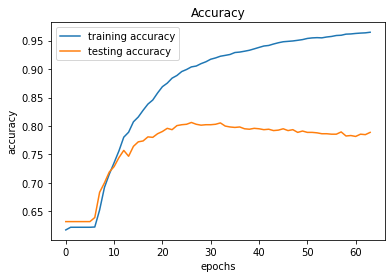

In [97]:
#plot accruacy and loss
# results2: val_accuracy, val_loss, accuracy,loss
plt.plot(fitmodel.history['accuracy'], label ='training accuracy')
plt.plot(fitmodel.history['val_accuracy'],label ='testing accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

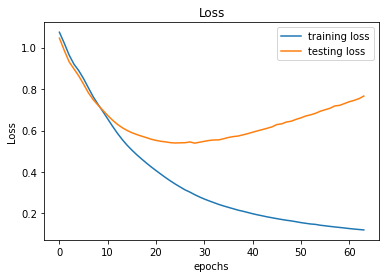

In [98]:
plt.plot(fitmodel.history['loss'], label ='training loss')
plt.plot(fitmodel.history['val_loss'],label ='testing loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

In [99]:
#review a prediction
r=50
#model
test_review = tens_test[r]
predict = model.predict([test_review])
print("Review: ")
print(decode_review(test_review))
print(decode_review(encoded_test[r]))
print("prediction: ",str(predict[0].round()))
print("Actual: ",str(t1_test_labels_onehot[r]))

Review: 
<START> met with agent all taken care of thx for reply <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<START> met with agent all taken care of thx for reply
prediction:  [0. 1. 0.]
Actual:  [0 0 1]


In [100]:
#anova
t1_train_labels_onehot

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [101]:
t1_test_labels_onehot

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [102]:
predict = model.predict(tens_test)

In [103]:
# len(predict)
print(predict[0].round(),t1_test_labels_onehot[0])

[1. 0. 0.] [1 0 0]


In [104]:
t1_p_labels_onehot = predict

In [105]:
#with rounded values
stats.f_oneway(t1_test_labels_onehot,t1_p_labels_onehot.round())

F_onewayResult(statistic=array([0.21644549, 0.5178301 , 3.4761621 ]), pvalue=array([0.64178706, 0.47181083, 0.0623322 ]))

In [106]:
predicted_labels = np.argmax(predict.round(),axis=1)
actual_labels = np.argmax(t1_test_labels_onehot,axis=1)

In [107]:
len(actual_labels)

2000

In [108]:
from sklearn.metrics import classification_report, accuracy_score

In [109]:
print('accuracy',accuracy_score(actual_labels,predicted_labels))

accuracy 0.774


In [110]:
print(classification_report(actual_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1301
           1       0.57      0.54      0.56       397
           2       0.73      0.63      0.68       302

    accuracy                           0.77      2000
   macro avg       0.71      0.68      0.70      2000
weighted avg       0.77      0.77      0.77      2000



In [111]:
pd.crosstab(predicted_labels,actual_labels)

col_0,0,1,2
row_0,,,
0,1141,150,69
1,121,216,42
2,39,31,191
